In [ ]:
# Installing necessary software
!pip install nltk
!pip install spacy==3.3.0
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

In [2]:
# Importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import random
from random import choice
import queue
import threading
import time
from numpy.core.fromnumeric import mean
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from IPython.display import clear_output

In [3]:
# Given dataset too small; Downloading a bigger one
nltk.download("twitter_samples")

# Downloading stopwords to filter later
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Compiling downloaded Twitter data into a dataframe
pos = nltk.corpus.twitter_samples.strings("positive_tweets.json")
neg = nltk.corpus.twitter_samples.strings("negative_tweets.json")

twitter_extra = pd.concat([pd.DataFrame(list(zip(pos, 
                                                 ['P' for i in range(len(pos))],
                                                 ['Twitter' for i in range(len(pos))])),
                                        columns = [0, 0, 0]),
                          pd.DataFrame(list(zip(neg, 
                                                ['N' for i in range(len(neg))],
                                                ['Twitter' for i in range(len(neg))])),
                                       columns = [0, 0, 0])])

In [6]:
# Compiling the rest of the data into dataframes
fbd = pd.read_csv("fb_data.txt", sep = "\n", header = None)
fbl = pd.read_csv("fb_label.txt", sep = "\n", header = None)
fbs = pd.DataFrame(['Facebook' for i in range(len(fbd))])
amd = pd.read_csv("amazon_data.txt", sep = "\n", header = None)
aml = pd.read_csv("amazon_label.txt", sep = "\n", header = None)
ams = pd.DataFrame(['Amazon' for i in range(len(amd))])
twd = pd.read_csv("tweets_data.txt", sep = "\n", header = None)
twl = pd.read_csv("tweets_label.txt", sep = "\n", header = None)
tws = pd.DataFrame(['Twitter' for i in range(len(twd))])

facebook = pd.concat([fbd, fbl, fbs], axis = 1)
amazon = pd.concat([amd, aml, ams], axis = 1)
twitter_base = pd.concat([twd, twl, tws], axis = 1)
twitter = pd.concat([twitter_base, twitter_extra])

In [7]:
# Concatenating all of the data into a single dataset
df = pd.concat([facebook, amazon, twitter])
x = df.iloc[:, [0, 2]].values
y = df.iloc[:, 1].values

# Splitting the dataset into train data, on which we will train our models, and
# test data, which will be used to simulate social media users
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, 
                                                    random_state = 0)
# Constructing a dataset to later sample simulated comments and replies from; 
# sentiment classification is removed for realism
simul = pd.concat([pd.DataFrame(x_test).iloc[:, 0], 
                   pd.DataFrame(['U' for i in range(len(x_test))]),
                   pd.DataFrame(x_test).iloc[:, 1]],
                  axis = 1)

In [8]:
# Defining the publication class, to which both comments and replies belong
class Publication:
  def __init__(self, content, sentiment, source, date, time):
      self.content = content
      self.sentiment = sentiment
      self.source = source
      self.date = date
      self.time = time

# Defining the user class, which is designed to simulate real internet users
class User:
  def __init__(self, comments, replies, userID, name):
    self.comments = comments
    self.replies = replies
    self.userID = userID
    self.name = name

# Defining the room class
class Room:
  def __init__(self, members, join_requests, name):
    self.members = members
    self.join_requests = join_requests
    self.name = name

In [26]:
# Initialising rooms and users
rooms = [Room([], [], 'Room%s' % (i+1)) for i in range(2)]
# Only 2 users because the computational strain is otherwise too high
users = [User([], [], [], []) for i in range(50)]

for user in users:
  comments = []
  replies = []
  # Creating sample names for users
  names = ["Jack", "John", "Max", "Arseniy", "Gregorz", "Mike", 
           "GoogleEnPassant", "GaryChess", "Jacob", "George",
           "HolyHell", "Rhosnes", "Mitch", "Moh"]
  numbers = list(range(1000))
  dates = [1, 2, 3, 4, 5]
  for i in range(int(np.random.normal(10, 5))):
    # Randomly sampling comments and replies from the dataset and assigning them
    # to our users
    comment = simul.sample()
    reply = simul.sample()
    comments.append(Publication(comment.iloc[0, 0], 
                                comment.iloc[0, 1],
                                comment.iloc[0, 2], 
                                choice(dates),
                                0))
    replies.append(Publication(reply.iloc[0, 0], 
                               reply.iloc[0, 1],
                               reply.iloc[0, 2],
                               choice(dates),
                               0))
  user.comments = comments
  user.replies = replies
  user.userID = users.index(user)
  # Randomly assigning names to users
  user.name = '%s%d' % (choice(names), choice(numbers))
  # Randomly selecting whether the users are going to be members or will request
  # access to each of the rooms
  for i in range(len(rooms)):
    status = choice([1, 2, 3, 4])
    if status == 1:
      rooms[i].members.append(user)
    if status == 2:
      rooms[i].join_requests.append(user)

In [10]:
# Initialising sentiment analysis components
tokeniser = RegexpTokenizer(pattern = '\w+|[:()@]+') # Emotics are vital to sentiment
# analysis and have raised the accuracy score of each of the models to be tested
# at least 5-fold
stopwords = nltk.corpus.stopwords.words("english")
ps = PorterStemmer()

In [11]:
# Preparing a clean piece of text ready for vectorisation
def clean(text, get_tokens = False):
  text = text.lower()
  tokens = tokeniser.tokenize(text)
  # Removing stopwords and hyperlinks, which aren't useful for sentiment analysis
  clean_tokens = [token for token in tokens if token not in stopwords
                  and not any(x in token for x in ['www', '.com', 'http'])]
  stemmed_tokens = [ps.stem(token) for token in clean_tokens]
  if not get_tokens:
    return " ".join(stemmed_tokens)
  # Creating a second purpose for the function to break down a piece of text into
  # a list of clean words and symbols
  else:
    return stemmed_tokens

In [12]:
# Generating the list of all words known to us so far in preparation for training
# our sentiment analysis models
vocab = []
for comment in x_train[:, 0]:
  for token in clean(comment, True):
    if token not in vocab:
      vocab.append(token)

In [13]:
# Writing a function to filter out words which aren't in our vocabulary, as the
# vocab vector that we will later use for model training will not contain
# a slot associated with those words
def filter(text):
  text_new = []
  for token in clean(text, True):
    if token in vocab:
      text_new.append(token)
  return " ".join(text_new)

In [14]:
# Splitting the train data even further to test the performance of our models
# without getting any information about the simulated users
Xtr, Xte, Ytr, Yte = train_test_split(x_train, y_train, test_size = 0.3, 
                                                    random_state = 0)
tv = TfidfVectorizer(ngram_range = (1, 2), vocabulary = vocab)

In [15]:
# Requesting sentiment data and a vectoriser to return machine-learning-ready 
# data; a pickle option is also there to preserve the vectoriser configuration
# for future pre-processing ─ this is necessary so that the dimensions of our
# vectorised data are always the same
def pre_process_1(x, vct, is_pickle):
  x_comments = [clean(i) for i in x[:, 0]]
  x_clean = np.array([[x_comments[i], x[i, 1]] for i in range(len(x))])
  x_trim = [[filter(i[0]), i[1]] for i in x_clean]
  x_comments = [i[0] for i in x_trim]

  x_vector = vct.fit_transform(x_comments).toarray()
  if is_pickle:
    s = pickle.dumps(vct)
    global tv2
    tv2 = pickle.loads(s)
  x_final = []
  # Encoding social medium source data
  onehot = pd.get_dummies([i[1] for i in x_trim])
  for i in range(len(x_trim)):
    x_final.append(np.concatenate([x_vector[i],
                                    onehot.iloc[i, :].tolist()]).tolist())
  return np.array(x_final)

In [16]:
# Pre-processing the training data and defining a pre-processing function with the
# previously configured vectoriser
Xtr_final = pre_process_1(Xtr, tv, True)
def pre_process_2(x):
  return pre_process_1(x, tv2, False)

In [17]:
# Loading a pre-templated sentiment analysis engine for comparison
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [18]:
# Testing the performance of the pre-templated engine
count = 0
pos_correct = 0
irr_correct = 0
neg_correct = 0

for comment in [clean(i) for i in Xte[:, 0]]:
  sent = nlp(comment)._.blob.polarity
  if Yte[count] == 'P':
    if sent >= 0.5:
      pos_correct += 1
  if Yte[count] == 'O':
    if sent > -0.5 and sent < 0.5:
      pos_correct += 1
  else:
    if sent <= -0.5:
      neg_correct += 1
  count += 1

spacy_accuracy = sum([pos_correct, irr_correct, neg_correct])/count

# Writing a function for getting predictions on input data from the engine
def spacy_pred(x):
  pred = []
  for comment in [clean(i) for i in x[:, 0]]:
    pred.append(nlp(comment)._.blob.polarity)
  return np.array(pred)

# Recording the performance of the engine
scores = [[spacy_accuracy, spacy_pred]]

In [30]:
# Training our own model and recording the performance; Naive Bayes is known to be
# an effective classifier of largely independent data such as a simple list of words
model = MultinomialNB()
model.fit(Xtr_final, Ytr)
s = pickle.dumps(model)
def Bayes(x):
  return pickle.loads(s).predict(pre_process_2(x))

scores.append([accuracy_score(Yte, Bayes(Xte)), Bayes])

In [31]:
# Training our neural network
model = MLPClassifier()
model.fit(Xtr_final, Ytr)
s = pickle.dumps(model)
def MLP(x):
  return pickle.loads(s).predict(pre_process_2(x))

scores.append([accuracy_score(Yte, MLP(Xte)), MLP])

In [32]:
# Outputing the performance of each model
scores

[[0.6288156288156288, <function __main__.spacy_pred>],
 [0.7032967032967034, <function __main__.Bayes>],
 [0.6857956857956858, <function __main__.MLP>]]

In [33]:
# While the custom-trained models performed better, they consumed all of Google
# Colab's RAM and frequently crashed the sessions, forcing me to use spacy's
# pre-trained model

sent_an = spacy_pred

In [34]:
# Defining a function to compute the sentiment scores of a user
def arasapps(user, aras = True):
  if aras:
    pubs = user.replies
  else:
    pubs = user.comments
  x = [[i.content, i.source] for i in pubs]
  return mean(sent_an(np.array(x)))

In [35]:
# Defining a function to compute the sentiment scores of a list of publications
def arasapps_list(pubs):
  return mean(sent_an(np.array(pubs)))

In [36]:
# Generating a thread designed to simulate users engaging in social media activities:
# writing comments, receiving replies, and joining, leaving, and requesting
# access to, rooms
def publication_sample():
    return [simul.iloc[:,[0,2]].sample().iloc[0,i] for i in range(2)]

class Event:
    # Exactly one of the following is NOT 0 or None:
    # - status_change_in_room = 0 - no change, 1 or 2 - room number
    # - comment = [text, source] or None
    # - reply = [text, source] or None
    def __init__(self, user_index, status_change_in_room, comment, reply):
        self.user_index = user_index
        self.date = 5
        self.timestamp = time.time_ns()
        self.status_change_in_room = status_change_in_room
        self.comment = comment
        self.reply = reply

    def __str__(self):
        if self.status_change_in_room != 0:
            return f"User {self.user_index}: Status change in room {self.status_change_in_room} at {self.timestamp}"
        else:
            what = 'Comment' if self.comment is not None else 'Reply'
            data = self.comment if self.comment is not None else self.reply
            return f"User {self.user_index}: {what} '{data[0]}' from {data[1]} at {self.timestamp}"


def generate_event(user_index, total_rooms):
    event_type = random.randrange(100)  # 40% - comment, next 40% - reply, next 20% - status change
    if event_type < 40:     # comment
        return Event(user_index, 0, publication_sample(), None)
    elif event_type < 80:   # reply
        return Event(user_index, 0, None, publication_sample())
    else:
        return Event(user_index, random.randint(1, total_rooms), None, None)


def wait_then_generate_event(user_index, total_rooms, event_queue):
    while True:
        time.sleep(random.randint(10, 110))  # uniform distribution around 60 seconds
        event_queue.put(generate_event(user_index, total_rooms))


def start_event_generation_threads(total_users, rooms, event_queue):
    threads = []
    for user_index in range(0, total_users):
        args = [user_index, len(rooms), event_queue]
        x = threading.Thread(target=wait_then_generate_event, args=args)
        threads.append(x)
    for x in threads:
        x.start()
    return threads

In [47]:
sent_scores = []
for user in users:
  sent_scores.append([arasapps(user), arasapps(user, False)])

In [45]:
def show_users_sentiments_pie_chart(sentiment_list, apps = True):
  all_labels = ['<-0.5', '[-0.5, -0.3)', '[-0.3, -0.1)', '[-0.1, 0.1)',
                '[0.1, 0.3]', '0.3, 0.5', '>0.5']
  boundaries = [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1]
  classes = [0 for _ in range(len(all_labels))]
  for s in sentiment_list:
      for bound_index in range(len(boundaries)):
          if s[int(apps)] < boundaries[bound_index]:
              classes[bound_index] += 1
              break
  # Don't show the missing classes
  labels = []
  values = []
  for i in range(len(classes)):
      if classes[i] > 0:
          labels.append(all_labels[i])
          values.append(classes[i])
  fig1, ax1 = plt.subplots()
  plt.title('User/sentiments')
  ax1.pie(values, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()


def show_comments_or_replies_bar_charts(comments, scores, title):
    date_to_scores = {}
    source_to_scores = {}
    for i in range(len(comments)):
        c = comments[i]
        date_to_scores.setdefault(c.date, []).append(scores[i])
        source_to_scores.setdefault(c.source, []).append(scores[i])
    date_to_average = {}
    for d in date_to_scores.keys():
        date_to_average[d] = sum(date_to_scores[d]) / len(date_to_scores[d])
    source_to_average = {}
    for s in source_to_scores.keys():
        source_to_average[s] = sum(source_to_scores[s]) / len(source_to_scores[s])
    dates = sorted(date_to_average.keys())
    date_scores = [date_to_average.get(d) for d in dates]
    plt.title(title + "date")
    show_bar_plot(dates, date_scores)
    sources = sorted(source_to_average.keys())
    source_scores = [source_to_average.get(s) for s in sources]
    plt.title(title + "source")
    show_bar_plot(sources, source_scores)


def show_user_graphs(user):
    comment_scores = [arasapps_list([[c.content, c.source]]) for c in user.comments]
    reply_scores = [arasapps_list([[r.content, r.source]]) for r in user.replies]
    if len(comment_scores):
        show_comments_or_replies_bar_charts(user.comments, comment_scores, f"{user.name}: APPS per ")
    if len(reply_scores):
        show_comments_or_replies_bar_charts(user.replies, reply_scores, f"{user.name}: ARAS per ")


def show_bar_plot(xlist, ylist, align='center'):
    """align = 'center' or 'edge' """
    plt.bar(xlist, ylist, width=0.7, align=align, linewidth=0, color='lightslategrey')
    plt.show()

def process_new_events(new_events):
  for event in new_events:
    user = users[event.user_index]
    if event.comment is not None:
      comment = event.comment
      user.comments.append(Publication(comment[0], None, comment[1], event.date,
                          event.timestamp))
    elif event.reply is not None:
      reply = event.reply
      user.replies.append(Publication(reply[0], None, reply[1], event.date,
                          event.timestamp))
    else:
      room_index = event.status_change_in_room - 1
      if user in rooms[room_index].members:
        rooms[room_index].members.remove(user)
      elif user in rooms[room_index].join_requests:
        rooms[room_index].join_requests.remove(user)
      else:
        rooms[room_index].join_requests.append(user)
  global sent_scores
  sent_scores = []
  for user in users:
    sent_scores.append([arasapps(user), arasapps(user, False)])
  for room in rooms:
    print("\n", room.name.upper())
    print("\t", "MEMBERS")
    for member in room.members:
      status = "safe"
      if sent_scores[member.userID][0] < -0.3:
        status = "likely bully"
      if sent_scores[member.userID][1] < -0.3:
        status = "likely troll"
      if sent_scores[member.userID][0] < -0.3 and sent_scores[member.userID][1] < -0.3:
        status = "high-threat"
      print(member.name, sent_scores[member.userID], status)
    print("\t", "JOIN REQUESTS")
    for member in room.join_requests:
      status = "safe"
      if sent_scores[member.userID][0] < -0.3:
        status = "likely bully"
      if sent_scores[member.userID][1] < -0.3:
        status = "likely troll"
      if sent_scores[member.userID][0] < -0.3 and sent_scores[member.userID][1] < -0.3:
        status = "high-threat"
      print(member.name, sent_scores[member.userID], status, "accept/decline")


 ROOM1
	 MEMBERS
John221 [0.07592592592592594, 0.03966666666666666] safe
GoogleEnPassant765 [-0.06666666666666665, -0.1186904761904762] safe
GaryChess3 [0.31666666666666665, 0.002083333333333326] safe
GoogleEnPassant484 [-0.05946969696969696, -0.032017543859649125] safe
Jack991 [0.3386363636363636, 0.17314814814814816] safe
Jacob465 [0.18256302521008405, -0.015185185185185178] safe
Jacob871 [-0.35000000000000003, 0.10873015873015873] likely bully
John561 [0.08333333333333333, -0.3194444444444445] likely troll
Mike11 [0.14791666666666667, 0.375] safe
George382 [-0.07238756613756614, -0.07765151515151518] safe
	 JOIN REQUESTS
Rhosnes82 [-0.014015151515151515, -0.20178571428571432] safe accept/decline
Arseniy678 [-0.01967171717171719, -0.13373737373737374] safe accept/decline
Gregorz222 [-0.056818181818181816, -0.013446969696969695] safe accept/decline
HolyHell265 [-0.13045238095238096, 0.08999999999999998] safe accept/decline
Jacob221 [0.2479166666666667, -0.09047619047619049] safe acce

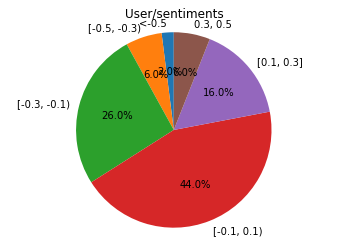

APPS SCORE DISTRIBUTION ACROSS ALL USERS


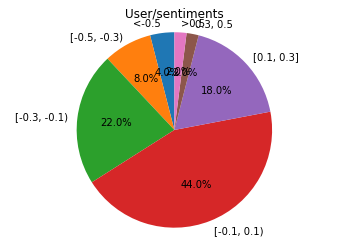

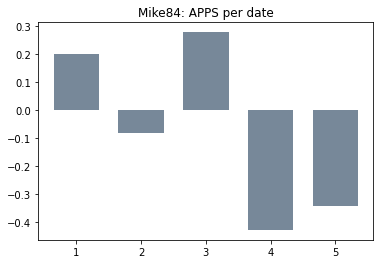

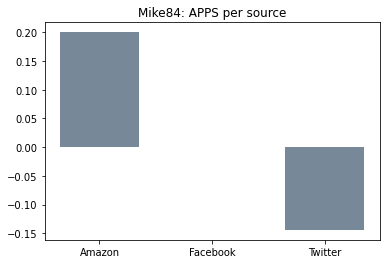

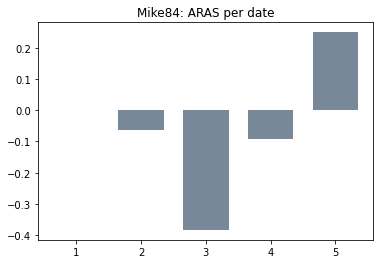

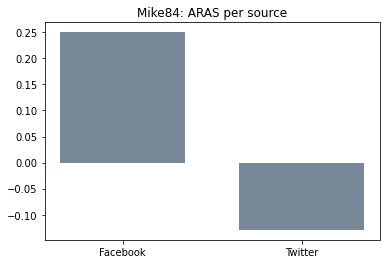

KeyboardInterrupt: ignored

In [48]:
event_queue = queue.SimpleQueue()
start_event_generation_threads(len(users), rooms, event_queue)
while True:
    new_events = []
    while not event_queue.empty():
        new_events.append(event_queue.get())
    if len(new_events):
      clear_output()
      process_new_events(new_events)
      user = choice(users)
      sentiments = sent_scores
      print("ARAS SCORE DISTRIBUTION ACROSS ALL USERS")
      show_users_sentiments_pie_chart(sentiments, False)
      print("APPS SCORE DISTRIBUTION ACROSS ALL USERS")
      show_users_sentiments_pie_chart(sentiments, True)
      show_user_graphs(user)
    time.sleep(10)